In [16]:
# Mount Google Drive (required if running on Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Install required modules
# !pip install '/content/drive/Team Drives/Deep Learning Team Drive/yelp_dataset_challenge-master/yelp_util'
!pip install Cython
# !pip install word2vec
!pip install gensim
!pip install unidecode
!pip install textblob
!pip install wordcloud


# Import required modules
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# import yelp_util
# from yelp_util import downloader as dl
import os
from scipy import misc
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
import pandas as pd
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Download and unpickle data
download_path =  '/content/drive/Team Drives/Deep Learning Team Drive/data'
review = pd.read_pickle(os.path.join(download_path, 'chinese_reviews.pickle'))
#review = review.loc[:, ['stars','text']] #use only stars & text columns

In [0]:
#PREOPROCESS A LITTLE BIT

#review2 = review.loc[:, ['stars','text']]
#review2.head()
review3 = review.loc[:, ['stars','text']]


In [25]:
#Option 1: review2 makes stars > 3 = positive, and the rest negative

#review2['sentiment']=['pos' if (x>3) else 'neg' for x in review2['stars']]
#review2.head()

#Option 2: review3 makes stars > 3 = positive, and stars = 2 or 1 negative. 3 are neutral/not considered for analysis.

#get rid of rows with 3 stars
review3 = review3[review3.stars != 3]
review3.stars.value_counts() # check that there are no "3" stars
review3['sentiment']=['pos' if (x>3) else 'neg' for x in review3['stars']] #add the sentiment column
review3.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,stars,text,sentiment
137,1,take it from me avoid this place at all cost ...,neg
138,2,far away from real chinese food doesnt even ta...,neg
139,2,i used to order takeout here once every month ...,neg
140,4,delicious singapore noodles and seafood deligh...,pos
142,1,all i can say is the worst we were the only 2 ...,neg


In [23]:
#lowercase/remove punctuations

import re
#review2['text']= [x.lower() for x in review2['text']]
#review2['text'] = review2['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
#review2.head()

review3['text']= [x.lower() for x in review3['text']]
review3['text'] = review3['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
review3.head()

,stars,text
136,3,don don is a restaurant i find myself missing ...
137,1,take it from me avoid this place at all cost ...
138,2,far away from real chinese food doesnt even ta...
139,2,i used to order takeout here once every month ...
140,4,delicious singapore noodles and seafood deligh...


In [0]:
#review2.dtypes
#review3.dtypes

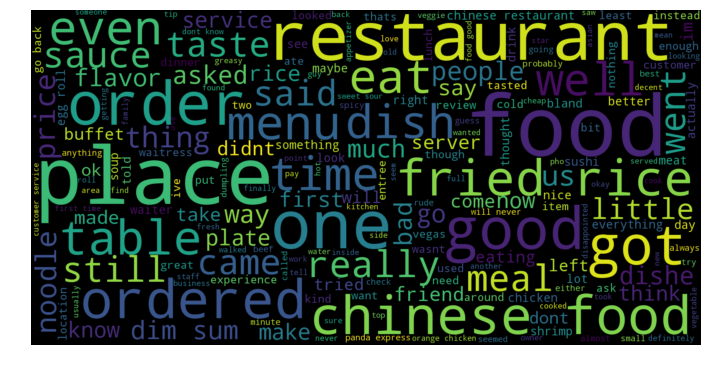

In [23]:
##Visualizations

## WordCloud for reviews with 1 or 2 stars ("negative" reviews) 
neg_review = review3[(review3['stars']==1) | (review3['stars']==2)]
neg_string = []
for t in neg_review.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

#negative reviews WordCloud (1,2 stars)
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

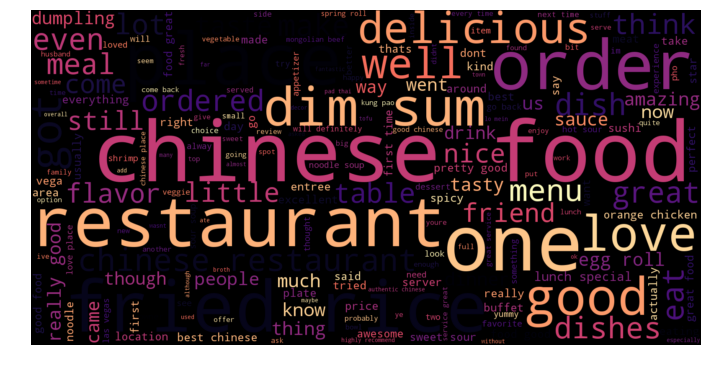

In [24]:
pos_review = review3[(review3['stars']==4) | (review3['stars']==5)]
pos_string = []
for t in pos_review.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

#Positive reviews WordCloud (4,5 stars)
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
review3.sentiment.value_counts()


pos    30987
neg    12030
Name: sentiment, dtype: int64

In [0]:
#################
#### L S T M ####
##### starts ####
##### here ###### 
#################

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, CuDNNLSTM, Bidirectional
from keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

tokenizer = Tokenizer(num_words=2000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',                                  
                      lower=True,split=' ')
#tokenizer.fit_on_texts(review2['text'].values)
tokenizer.fit_on_texts(review3['text'].values)

In [28]:
#Use Tokenizer to vectorize the text and convert it into sequence of integers 
tokenizer

In [0]:
#X = tokenizer.texts_to_sequences(review2['text'].values)
X = tokenizer.texts_to_sequences(review3['text'].values)
X = pad_sequences(X)

In [30]:
#len(review2) #output: 51984
len(review3) #output: 43017

43017

In [48]:
### The following sections ###
### were exectued with the following hyper parameters ###
#embed_dim = 128
#lstm_out = 200
#batch_size = 32
#dropout layer
#vocabulary size = 2000

#activation function - softmax
#optimized = sgd

embed_dim = 128
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(Embedding(2000, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(CuDNNLSTM(lstm_out, return_sequences=False, input_shape=(864, 128)))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 870, 128)          256000    
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 870, 128)          0         
_________________________________________________________________
cu_dnnlstm_13 (CuDNNLSTM)    (None, 200)               264000    
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 402       
Total params: 520,402
Trainable params: 520,402
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
#Y = pd.get_dummies(review2['sentiment']).values
Y = pd.get_dummies(review3['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

NameError: ignored

In [49]:
#run with "review3" - option 2 with ADAM optimizer, sigmoid, binary_crossentropy and current: softmax & categorical crossentropy
model.fit(X_train, Y_train, batch_size = batch_size, epochs = 3, verbose = 2)

Epoch 1/3
 - 205s - loss: 0.2642 - acc: 0.8940
Epoch 2/3
 - 203s - loss: 0.1737 - acc: 0.9347
Epoch 3/3
 - 203s - loss: 0.3346 - acc: 0.8476


In [31]:
#run with "review3" - option 2 with RMSProp optimizer
model.fit(X_train, Y_train, batch_size = batch_size, epochs = 3, verbose = 2)

Epoch 1/3
 - 203s - loss: 0.2775 - acc: 0.8903
Epoch 2/3
 - 202s - loss: 0.1755 - acc: 0.9346
Epoch 3/3
 - 202s - loss: 0.1433 - acc: 0.9460


In [34]:
#run with "review3" - option 2 with SGD optimizer
model.fit(X_train, Y_train, batch_size = batch_size, epochs = 3, verbose = 2)

Epoch 1/3
 - 203s - loss: 0.5932 - acc: 0.7209
Epoch 2/3
 - 202s - loss: 0.5904 - acc: 0.7211
Epoch 3/3
 - 202s - loss: 0.5887 - acc: 0.7211


In [32]:
#score: evaluation of the loss function
#loss/accuracy
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

Score: 0.60
Validation Accuracy: 0.71


In [54]:
### The following sections ###
### were exectued with the following hyper parameters ###
#embed_dim = 128
#lstm_out = 200
#batch_size = 32
#dropout layer
#vocabulary size = 2000

#activation function - softmax
#optimized = adam
#uses CuDNNLSTM !!!!! (GPU powered)


embed_dim = 128
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(Embedding(2000, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(CuDNNLSTM(lstm_out, return_sequences=False, input_shape=(864, 128)))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 870, 128)          256000    
_________________________________________________________________
spatial_dropout1d_17 (Spatia (None, 870, 128)          0         
_________________________________________________________________
cu_dnnlstm_16 (CuDNNLSTM)    (None, 200)               264000    
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 402       
Total params: 520,402
Trainable params: 520,402
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
#try review2
#Y = pd.get_dummies(review2['sentiment']).values
#X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)
#print(X_train.shape,Y_train.shape)
#print(X_test.shape,Y_test.shape)

In [55]:
#Y = pd.get_dummies(review2['sentiment']).values
Y = pd.get_dummies(review3['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(38715, 870) (38715, 2)
(4302, 870) (4302, 2)


In [89]:
#run with "review3" - option 2 with ADAM optimizer
#sooooooooo much faster!!!
model.fit(X_train, Y_train, batch_size = batch_size, epochs = 3, verbose = 2)

Epoch 1/3
 - 206s - loss: 0.2727 - acc: 0.8902
Epoch 2/3
 - 203s - loss: 0.1855 - acc: 0.9308
Epoch 3/3
 - 204s - loss: 0.1357 - acc: 0.9494


In [90]:
#score: evaluation of the loss function
#loss/accuracy
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

Score: 0.17
Validation Accuracy: 0.94


In [56]:
#LET'S PLOT IT
history = model.fit(X, Y, validation_split=0.1, epochs=10, batch_size=batch_size, verbose=2)

Train on 38715 samples, validate on 4302 samples
Epoch 1/10
 - 214s - loss: 0.2822 - acc: 0.8860 - val_loss: 0.2089 - val_acc: 0.9193
Epoch 2/10
 - 212s - loss: 0.1758 - acc: 0.9338 - val_loss: 0.1418 - val_acc: 0.9482
Epoch 3/10
 - 212s - loss: 0.1383 - acc: 0.9470 - val_loss: 0.1309 - val_acc: 0.9537
Epoch 4/10
 - 211s - loss: 0.1102 - acc: 0.9597 - val_loss: 0.1297 - val_acc: 0.9537
Epoch 5/10
 - 212s - loss: 0.0948 - acc: 0.9644 - val_loss: 0.1399 - val_acc: 0.9528
Epoch 6/10
 - 212s - loss: 0.0812 - acc: 0.9693 - val_loss: 0.1309 - val_acc: 0.9561
Epoch 7/10
 - 212s - loss: 0.0721 - acc: 0.9738 - val_loss: 0.1468 - val_acc: 0.9540
Epoch 8/10
 - 212s - loss: 0.0587 - acc: 0.9782 - val_loss: 0.1603 - val_acc: 0.9470
Epoch 9/10
 - 212s - loss: 0.0493 - acc: 0.9816 - val_loss: 0.1689 - val_acc: 0.9542
Epoch 10/10
 - 212s - loss: 0.0429 - acc: 0.9849 - val_loss: 0.1839 - val_acc: 0.9489


In [0]:
#print(history.history.keys())

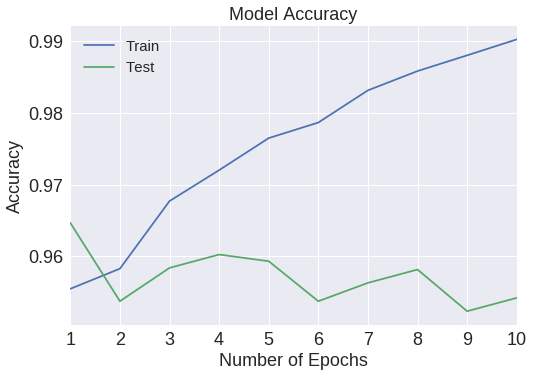

In [189]:
# plot accuracy over 10 epochs
history.history['acc']

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy',fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Number of Epochs', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', fontsize=15)
plt.xlim(0,9)
plt.xticks([0,1,2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8,9,10]) #make the labels neater
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=17)
plt.show()



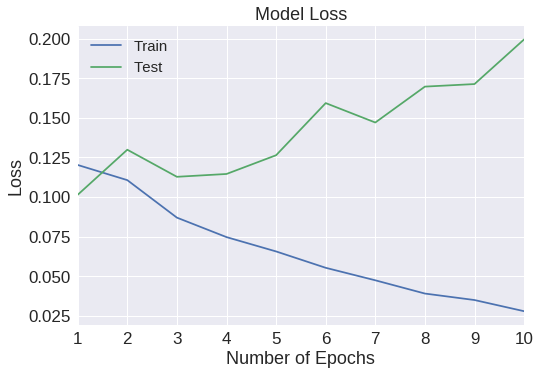

In [191]:
# plot loss over 10 epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.xlabel('Number of Epochs',fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', fontsize=15)
plt.xlim(0,9)
plt.xticks([0,1,2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8,9,10]) #make the labels neater
plt.show()

In [13]:
#activation function - SIGMOID

embed_dim = 128
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(Embedding(2000, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(CuDNNLSTM(lstm_out, return_sequences=False, input_shape=(864, 128)))
model.add(Dense(2,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 870, 128)          256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 870, 128)          0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 200)               264000    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 520,402
Trainable params: 520,402
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
Y = pd.get_dummies(review3['sentiment']).values
#LET'S PLOT IT
history2 = model.fit(X, Y, validation_split=0.1, epochs=10, batch_size=batch_size, verbose=2)

Train on 38715 samples, validate on 4302 samples
Epoch 1/10
 - 214s - loss: 0.2899 - acc: 0.8815 - val_loss: 0.1567 - val_acc: 0.9391
Epoch 2/10
 - 209s - loss: 0.1726 - acc: 0.9350 - val_loss: 0.1456 - val_acc: 0.9458
Epoch 3/10
 - 209s - loss: 0.1587 - acc: 0.9383 - val_loss: 0.1283 - val_acc: 0.9530
Epoch 4/10
 - 209s - loss: 0.1151 - acc: 0.9561 - val_loss: 0.1225 - val_acc: 0.9551
Epoch 5/10
 - 209s - loss: 0.0990 - acc: 0.9625 - val_loss: 0.1242 - val_acc: 0.9586
Epoch 6/10
 - 209s - loss: 0.0893 - acc: 0.9668 - val_loss: 0.1362 - val_acc: 0.9549
Epoch 7/10
 - 209s - loss: 0.0748 - acc: 0.9724 - val_loss: 0.1457 - val_acc: 0.9568
Epoch 8/10
 - 209s - loss: 0.0668 - acc: 0.9753 - val_loss: 0.1500 - val_acc: 0.9591
Epoch 9/10
 - 209s - loss: 0.0576 - acc: 0.9785 - val_loss: 0.1469 - val_acc: 0.9572
Epoch 10/10
 - 209s - loss: 0.0488 - acc: 0.9824 - val_loss: 0.1619 - val_acc: 0.9554


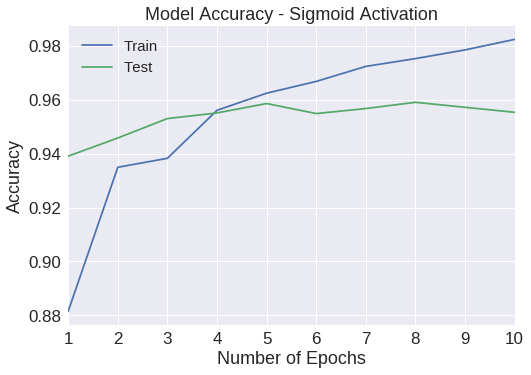

In [20]:
# plot accuracy over 10 epochs
history2.history['acc']

plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model Accuracy - Sigmoid Activation',fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Number of Epochs', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', fontsize=15)
plt.xlim(0,9)
plt.xticks([0,1,2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8,9,10]) #make the labels neater
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=17)
plt.show()





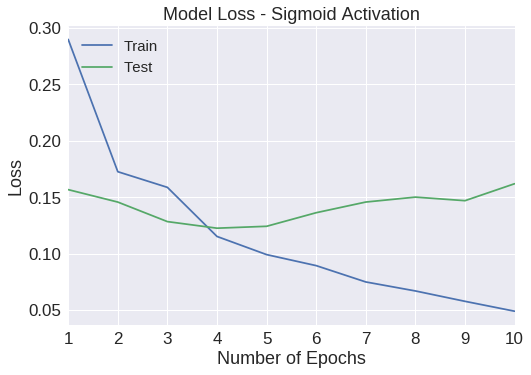

In [21]:
# plot loss over 10 epochs
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss - Sigmoid Activation',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.xlabel('Number of Epochs',fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', fontsize=15)
plt.xlim(0,9)
plt.xticks([0,1,2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8,9,10]) #make the labels neater
plt.show()

In [0]:
###################
## Bidirectional ##
##### L S T M #####
###### starts #####
####### here ######
###################

In [53]:
from keras.layers import Bidirectional, GlobalMaxPool1D,Conv1D

embed_dim = 128
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(Embedding(2000, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(CuDNNLSTM(lstm_out, return_sequences=True, input_shape=(864, 128))))
model.add(Bidirectional(CuDNNLSTM(lstm_out)))
model.add(Dense(2,activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 870, 128)          256000    
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 870, 128)          0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 870, 400)          528000    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 400)               963200    
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 802       
Total params: 1,748,002
Trainable params: 1,748,002
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
Y = pd.get_dummies(review3['sentiment']).values
#LET'S PLOT IT
history3 = model.fit(X, Y, validation_split=0.1, epochs=5, batch_size=batch_size, verbose=2)

Train on 38715 samples, validate on 4302 samples
Epoch 1/5
 - 855s - loss: 0.3128 - acc: 0.8671 - val_loss: 0.1852 - val_acc: 0.9305
Epoch 2/5
 - 853s - loss: 0.1913 - acc: 0.9284 - val_loss: 0.1366 - val_acc: 0.9526
Epoch 3/5
 - 853s - loss: 0.1499 - acc: 0.9444 - val_loss: 0.1117 - val_acc: 0.9603
Epoch 4/5
 - 854s - loss: 0.1271 - acc: 0.9536 - val_loss: 0.1159 - val_acc: 0.9607
Epoch 5/5
 - 853s - loss: 0.1149 - acc: 0.9592 - val_loss: 0.1114 - val_acc: 0.9596


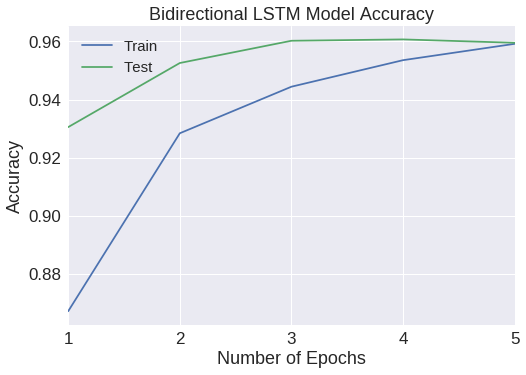

In [58]:
# plot accuracy over 5 epochs
history3.history['acc']

plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('Bidirectional LSTM Model Accuracy',fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Number of Epochs', fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', fontsize=15)
plt.xlim(0,4)
plt.xticks([0,1,2,3,4], [1,2,3,4,5]) #make the labels neater
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=17)
plt.show()





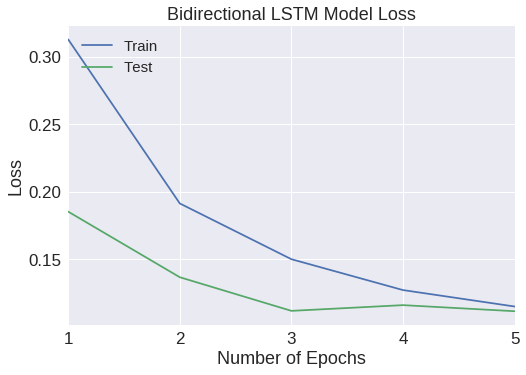

In [59]:
# plot loss over 10 epochs
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Bidirectional LSTM Model Loss',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.xlabel('Number of Epochs',fontsize=18)
plt.legend(['Train', 'Test'], loc='upper left', fontsize=15)
plt.xlim(0,4)
plt.xticks([0,1,2,3,4], [1,2,3,4,5]) #make the labels neater
plt.show()